In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CUB200Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = pd.read_csv(os.path.join(root_dir, 'images.txt'), sep=' ', names=['id', 'filepath'])
        self.labels = pd.read_csv(os.path.join(root_dir, 'image_class_labels.txt'), sep=' ', names=['id', 'label'])
        self.bboxes = pd.read_csv(os.path.join(root_dir, 'bounding_boxes.txt'), sep=' ', names=['id', 'x', 'y', 'width', 'height'])
        print(self.images)
        print("--------------------")
        print(self.labels)
        print("--------------------")
        print(self.bboxes)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'images', self.images.iloc[idx]['filepath'])
        image = Image.open(img_name).convert('RGB')  # Ensuring image is RGB
        bbox = self.bboxes.iloc[idx][['x', 'y', 'width', 'height']].tolist()
        label = self.labels.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        bbox = tuple(bbox) if isinstance(bbox, list) else bbox

        return image, label, bbox


def cub_transform(image_size=448):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))
    ])

    val_transform = transforms.Compose([
        transforms.Resize(int(image_size / 0.875)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))
    ])
    
    return train_transform, val_transform

# Usage
train_transform, val_transform = cub_transform()
train_dataset = CUB200Dataset(root_dir='CUB_200_2011/CUB_200_2011', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

          id                                           filepath
0          1  001.Black_footed_Albatross/Black_Footed_Albatr...
1          2  001.Black_footed_Albatross/Black_Footed_Albatr...
2          3  001.Black_footed_Albatross/Black_Footed_Albatr...
3          4  001.Black_footed_Albatross/Black_Footed_Albatr...
4          5  001.Black_footed_Albatross/Black_Footed_Albatr...
...      ...                                                ...
11783  11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784  11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785  11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786  11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787  11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
--------------------
          id  label
0          1      1
1          2      1
2          3      1
3          4      1
4          5      1
...      ...    ...
11783  11784    200
11784  11785    200
11785

In [2]:
import torch
from torchvision import models


model = models.resnet50(pretrained=True)


model.load_state_dict(torch.load('cub_pytorch_resnet50.pth'))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

[65.0, 26.0, 103.0, 85.0]
90 71 358 299


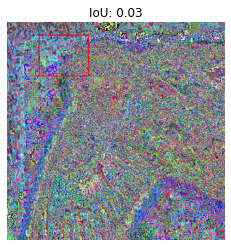

In [6]:
import torch
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
from torchvision.transforms.functional import to_pil_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)
model.load_state_dict(torch.load('cub_pytorch_resnet50.pth'))
model = model.to(device)
model.eval()

class ResNetGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradient = None
        self.feature_map = None
        self.handles = []

    def save_gradient(self, grad):
        self.gradient = grad

    def forward_hook(self, module, input, output):
        self.feature_map = output
        handle = output.register_hook(self.save_gradient)
        self.handles.append(handle)

    def __enter__(self):
        self.handles.append(self.model.layer4.register_forward_hook(self.forward_hook))
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        for handle in self.handles:
            handle.remove()

    def compute_gradcam(self, output, class_idx):
        """
        Computes Grad-CAM for a specified class.
        Args:
            output: The model output after forward pass (logits).
            class_idx: Index of the target class for which CAM is to be computed.
        """
        self.model.zero_grad()
        class_score = output[:, class_idx] 
        class_score.backward(gradient=torch.ones_like(class_score), retain_graph=True)  

        pooled_gradients = torch.mean(self.gradient, dim=[0, 2, 3])
        for i in range(pooled_gradients.size(0)):
            self.feature_map[0][i, :, :] *= pooled_gradients[i]

        cam = torch.sum(self.feature_map[0], dim=0).detach()  # Sum all weighted feature maps
        cam = torch.relu(cam)  # Apply ReLU to keep only positive features
        cam = cam - cam.min()  # Normalize the CAM to visualize
        cam = cam / cam.max()
        return cam.numpy()
    
import cv2

def extract_high_intensity_region(heatmap, threshold=0.5):

    _, thresholded = cv2.threshold(heatmap, threshold * heatmap.max(), 255, cv2.THRESH_BINARY)
    thresholded = np.uint8(thresholded)
    

    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        print(x,y,w,h)
        return x, y, w, h
    return 0, 0, 0, 0  # If no contours are found

def calculate_iou(box1, box2):
    try:
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
    except ValueError as e:
        print(f"Error unpacking boxes - Box1: {box1}, Box2: {box2}")
        raise e


    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0


    intersection_area = (x_right - x_left) * (y_bottom - y_top)


    box1_area = w1 * h1
    box2_area = w2 * h2

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

def visualize_cam_on_image(img_tensor, cam, bbox):
    img = to_pil_image(img_tensor) 
    cam_image = Image.fromarray((cam * 255).astype(np.uint8)) 
    cam_image = cam_image.resize(img.size, Image.BILINEAR)

    cam_np = np.array(cam_image)
    heatmap = plt.cm.jet(cam_np)[:, :, :3]  
    combined = heatmap * 0.3 + np.array(img) * 0.7 

    # Draw bounding box on the combined image
    combined_pil = Image.fromarray((combined * 255).astype(np.uint8))
    draw = ImageDraw.Draw(combined_pil)
    x, y, w, h = bbox
    draw.rectangle([x, y, x+w, y+h], outline="red", width=2)

    high_intensity_bbox = extract_high_intensity_region(cam_np, threshold=0.5)
    iou = calculate_iou(bbox, high_intensity_bbox)

    plt.imshow(combined_pil)
    plt.title(f'IoU: {iou:.2f}')
    plt.axis('off')
    plt.show()

    return iou

with ResNetGradCAM(model) as gradcam:
    for images, labels, bboxes in train_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(dim=1)

        for i in range(images.size(0)):
            cam = gradcam.compute_gradcam(outputs, labels[i].item())
            # Ensure bbox is a flat list of four elements
            bbox = bboxes[i].tolist() if isinstance(bboxes[i], torch.Tensor) else bboxes[i]
            if isinstance(bbox, list) and len(bbox) != 4:
                bbox = bbox[:4]  # Ensure only four elements are there
                print(bbox)
            visualize_cam_on_image(images[i], cam, bbox)
            break
        break




          id                                           filepath
0          1  001.Black_footed_Albatross/Black_Footed_Albatr...
1          2  001.Black_footed_Albatross/Black_Footed_Albatr...
2          3  001.Black_footed_Albatross/Black_Footed_Albatr...
3          4  001.Black_footed_Albatross/Black_Footed_Albatr...
4          5  001.Black_footed_Albatross/Black_Footed_Albatr...
...      ...                                                ...
11783  11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784  11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785  11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786  11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787  11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
--------------------
          id  label
0          1      1
1          2      1
2          3      1
3          4      1
4          5      1
...      ...    ...
11783  11784    200
11784  11785    200
11785

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


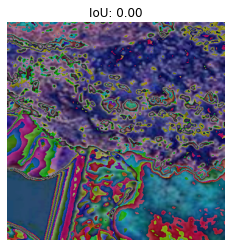